# Importing libraries and initialization of the environment

In [10]:
# Environment
import gymnasium as gym
import highway_env

# Models and computation
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import namedtuple

# Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import trange
from config_parking import config

# IO
from pathlib import Path

In [11]:
env = gym.make("parking-v0", render_mode="rgb_array")

In [12]:
env.unwrapped.configure(config)

In [13]:
import cv2

In [14]:
frames = []  # List to store each frame as an RGB array

observation = env.reset()
done = False
while not done:
    action = env.action_space.sample()  # Random action; replace as needed
    observation, reward, done, info,_ = env.step(action)
    frames.append(env.render())

env.close()

In [15]:
# Define video settings
path = 'parking_env_episode.avi'  # Save path
fps = 20  # Frames per second
frame_size = (frames[0].shape[1], frames[0].shape[0])  # Frame size (width, height)

# Initialize video writer
fourcc = cv2.VideoWriter_fourcc(*'DIVX')  # Codec
out = cv2.VideoWriter(path, fourcc, fps, frame_size)

# Write frames to video
for frame in frames:
    out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert RGB to BGR format

out.release()  # Finalize and close the video writer


In [16]:
import cv2
import gym
from pathlib import Path
import numpy as np
from IPython.display import HTML
from base64 import b64encode

class RecordVideos(gym.Wrapper):
    def __init__(self, env, save_dir="videos", fps=20):
        super().__init__(env)
        self.frames = []
        self.save_dir = Path(save_dir)
        self.fps = fps
        self.save_dir.mkdir(parents=True, exist_ok=True)
        self.video_path = None

    def reset(self, **kwargs):
        self.frames = []
        return super().reset(**kwargs)

    def step(self, action):
        observation, reward, done, truncated, info = super().step(action)
        self.frames.append(self.env.render())
        return observation, reward, done, truncated, info

    def close(self):
        if self.frames:
            self.save_video()
        super().close()

    def save_video(self):
        video_id = len(list(self.save_dir.glob("*.avi"))) + 1
        self.video_path = self.save_dir / f"episode_{video_id}.avi"
        frame_size = (self.frames[0].shape[1], self.frames[0].shape[0])
        out = cv2.VideoWriter(str(self.video_path), cv2.VideoWriter_fourcc(*'DIVX'), self.fps, frame_size)
        for frame in self.frames:
            out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
        out.release()

def record_videos(env):
    return RecordVideos(env)


## Experience collection

In [17]:
from collections import namedtuple
import torch
from tqdm import trange
import gym

Transition = namedtuple('Transition', ['state', 'action', 'next_state'])

def collect_interaction_data(env, size=1000, action_repeat=2):
    state_data, action_data, next_state_data = [], [], []
    done = True

    for _ in trange(size, desc="Collecting interaction data"):
        if done:
            state, info = env.reset()
        action = env.action_space.sample()
        
        for _ in range(action_repeat):
            next_state, reward, done, truncated, info = env.step(action)
            state_data.append(state["observation"])
            action_data.append([action])  # Keep the action in a list to maintain the correct structure
            next_state_data.append(next_state["observation"])
            state = next_state

    # Convert lists of arrays to tensors
    state_tensor = torch.tensor(np.array(state_data), dtype=torch.float32)
    action_tensor = torch.tensor(np.array(action_data), dtype=torch.float32)
    next_state_tensor = torch.tensor(np.array(next_state_data), dtype=torch.float32)
    
    # Zip the tensors to create a list of Transitions
    data = [Transition(s, a, ns) for s, a, ns in zip(state_tensor, action_tensor, next_state_tensor)]
    return data



In [18]:
# Collect interaction data
data = collect_interaction_data(env)

# Print a sample transition
print("Sample transition:", data[0])

Sample transition: Transition(state=tensor([ 0.0000,  0.0000, -0.0000, -0.0000, -0.4318, -0.9020]), action=tensor([[-0.3259, -0.6564]]), next_state=tensor([ 1.4361e-04,  1.6305e-04,  2.8007e-02,  5.8860e-02, -4.2967e-01,
        -9.0299e-01]))


In [19]:
data[0].state.shape

torch.Size([6])

## Dynamic Model

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DynamicsModel(nn.Module):
    def __init__(self, state_size, action_size, hidden_size, dt):
        super().__init__()
        self.state_size, self.action_size, self.dt = state_size, action_size, dt
        A_size, B_size = state_size * state_size, state_size * action_size
        self.A1 = nn.Linear(state_size + action_size, hidden_size)
        self.A2 = nn.Linear(hidden_size, A_size)
        self.B1 = nn.Linear(state_size + action_size, hidden_size)
        self.B2 = nn.Linear(hidden_size, B_size)

    def forward(self, x, u):
        """
        Predict x_{t+1} = f(x_t, u_t)
        :param x: a batch of states
        :param u: a batch of actions
        """
        # Ensure that x and u have the same batch size in the first dimension
        if x.ndim == 1:
            x = x.unsqueeze(0)  # Add batch dimension if missing
        if x.ndim == 1:
            x = x.unsqueeze(0)  # Add batch dimension if missing
        if u.ndim > 2:
            u = u.squeeze(1)
        #print(x.shape, u.shape)
        xu = torch.cat((x, u), dim=-1)
        
        A = self.A2(F.relu(self.A1(xu)))
        A = A.view(-1, self.state_size, self.state_size)  # Use view for reshaping
        B = self.B2(F.relu(self.B1(xu)))
        B = B.view(-1, self.state_size, self.action_size)  # Use view for reshaping
        
        # Apply dynamics
        dx = A.bmm(x.unsqueeze(-1)) + B.bmm(u.unsqueeze(-1))  # Use batch matrix multiplication
        next_state = x + dx.squeeze(-1) * self.dt

        return next_state


In [21]:
dynamics = DynamicsModel(state_size=env.observation_space.spaces["observation"].shape[0],
                         action_size=env.action_space.shape[0],
                         hidden_size=64,
                         dt=1/env.unwrapped.config["policy_frequency"])



In [22]:
# Assuming data[0].action.shape is [1, action_size] after unsqueezing
state_tensor = data[0].state.unsqueeze(0)  # Adds a batch dimension, shape becomes [1, 6]
action_tensor = data[0].action  # If action is already [1, action_size], no need to unsqueeze

# Now, if action_tensor is not the correct shape, let's adjust it
# Check the shape first
"""
print("Action shape before adjustment:", action_tensor.shape)

# If action_tensor is [1, 1, action_size], we need to remove the unnecessary middle dimension
if action_tensor.dim() == 3 and action_tensor.shape[1] == 1:
    action_tensor = action_tensor.squeeze(1)  # Now shape becomes [1, action_size]

# Double check shapes before passing to dynamics model
print("State tensor shape:", state_tensor.shape)
print("Action tensor shape:", action_tensor.shape)
"""
# Forward pass through the dynamics model
predicted_next_state = dynamics(state_tensor, action_tensor).detach()
print("Forward initial model on a sample transition:", predicted_next_state)


Forward initial model on a sample transition: tensor([[ 4.0176e-04, -1.6560e-02, -7.7372e-02,  1.4338e-02, -4.9447e-01,
         -9.0843e-01]])


## Fit the model on data

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split

dataset = data  # Assuming 'data' is a list of Transition namedtuples
train_ratio = 0.7
train_count = int(train_ratio * len(dataset))
train_dataset, validation_dataset = random_split(dataset, [train_count, len(dataset) - train_count])

# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64)

optimizer = torch.optim.Adam(dynamics.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

# Setup TensorBoard writer
writer = SummaryWriter()

def train(model, train_loader, validation_loader, epochs=1500):
    for epoch in trange(epochs, desc="Train dynamics"):
        model.train()  # Set model to training mode
        total_train_loss = 0
        for batch in train_loader:
            states, actions, next_states = batch
            optimizer.zero_grad()
            predictions = model(states, actions)
            loss = loss_func(predictions, next_states)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * len(states)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        total_validation_loss = 0
        with torch.no_grad():
            for batch in validation_loader:
                states, actions, next_states = batch
                predictions = model(states, actions)
                validation_loss = loss_func(predictions, next_states)
                total_validation_loss += validation_loss.item() * len(states)

        # Calculate average losses
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        avg_validation_loss = total_validation_loss / len(validation_loader.dataset)

        # Log to TensorBoard
        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        writer.add_scalar('Loss/Validation', avg_validation_loss, epoch)

        if (epoch + 1) % 100 == 0:  # Print every 100 epochs
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_validation_loss:.4f}")

# Finally, train the model
train(dynamics, train_loader, validation_loader)

# Close the TensorBoard writer
writer.close()


Train dynamics:   7%|▋         | 102/1500 [00:05<01:19, 17.60it/s]

Epoch 100/1500, Train Loss: 0.0001, Validation Loss: 0.0004


Train dynamics:  13%|█▎        | 202/1500 [00:12<01:14, 17.31it/s]

Epoch 200/1500, Train Loss: 0.0002, Validation Loss: 0.0005


Train dynamics:  20%|██        | 302/1500 [00:17<01:06, 18.04it/s]

Epoch 300/1500, Train Loss: 0.0001, Validation Loss: 0.0005


Train dynamics:  27%|██▋       | 402/1500 [00:23<01:00, 18.28it/s]

Epoch 400/1500, Train Loss: 0.0001, Validation Loss: 0.0010


Train dynamics:  33%|███▎      | 501/1500 [00:30<01:21, 12.28it/s]

Epoch 500/1500, Train Loss: 0.0001, Validation Loss: 0.0008


Train dynamics:  40%|████      | 601/1500 [00:38<01:00, 14.95it/s]

Epoch 600/1500, Train Loss: 0.0001, Validation Loss: 0.0007


Train dynamics:  47%|████▋     | 701/1500 [00:45<00:58, 13.73it/s]

Epoch 700/1500, Train Loss: 0.0000, Validation Loss: 0.0006


Train dynamics:  53%|█████▎    | 801/1500 [00:52<00:59, 11.84it/s]

Epoch 800/1500, Train Loss: 0.0001, Validation Loss: 0.0006


Train dynamics:  60%|██████    | 901/1500 [01:01<00:45, 13.26it/s]

Epoch 900/1500, Train Loss: 0.0001, Validation Loss: 0.0007


Train dynamics:  67%|██████▋   | 1001/1500 [01:09<00:35, 13.96it/s]

Epoch 1000/1500, Train Loss: 0.0001, Validation Loss: 0.0006


Train dynamics:  73%|███████▎  | 1101/1500 [01:17<00:40,  9.82it/s]

Epoch 1100/1500, Train Loss: 0.0001, Validation Loss: 0.0005


Train dynamics:  80%|████████  | 1201/1500 [01:24<00:21, 14.20it/s]

Epoch 1200/1500, Train Loss: 0.0001, Validation Loss: 0.0005


Train dynamics:  87%|████████▋ | 1301/1500 [01:32<00:17, 11.27it/s]

Epoch 1300/1500, Train Loss: 0.0001, Validation Loss: 0.0006


Train dynamics:  93%|█████████▎| 1401/1500 [01:39<00:07, 13.84it/s]

Epoch 1400/1500, Train Loss: 0.0001, Validation Loss: 0.0005


Train dynamics: 100%|██████████| 1500/1500 [01:47<00:00, 13.96it/s]

Epoch 1500/1500, Train Loss: 0.0001, Validation Loss: 0.0007


## Visualize trained dynamics

In [24]:
def predict_trajectory(state, actions, model, action_repeat=1):
    states = []
    for action in actions:
        for _ in range(action_repeat):
            state = model(state, action)
            states.append(state)
    return torch.stack(states, dim=0)

In [25]:
def plot_trajectory(states, color, label):
    scales = np.array(env.unwrapped.config["observation"]["scales"])
    states = np.clip(states.squeeze(1).detach().numpy() * scales, -100, 100)
    plt.plot(states[:, 0], states[:, 1], color=color, marker='.', label=label)
    plt.arrow(states[-1, 0], states[-1, 1], states[-1, 4]*1, states[-1, 5]*1, color=color, head_width=0.5)


In [26]:
def visualize_trajectories(model, state, horizon=15):
    plt.cla()
    # Draw a car
    plt.plot(state.numpy()[0]+2.5*np.array([-1, -1, 1, 1, -1]),
             state.numpy()[1]+1.0*np.array([-1, 1, 1, -1, -1]), 'k', label='Car')
    
    state = state.unsqueeze(0)
    colors = iter(plt.get_cmap("tab20").colors)
    
    # Generate commands and predict trajectories
    for i, steering in enumerate(np.linspace(-0.5, 0.5, 3)):
        for j, acceleration in enumerate(np.linspace(0.8, 0.4, 2)):
            actions = torch.Tensor([acceleration, steering]).view(1, 1, -1)
            states = predict_trajectory(state, actions, model, action_repeat=horizon)
            label = f'Steering {steering:.2f}, Acc {acceleration:.2f}'
            plot_trajectory(states, color=next(colors), label=label)
    
    plt.axis("equal")
    plt.legend()  # Add this to show the legend
    plt.show()


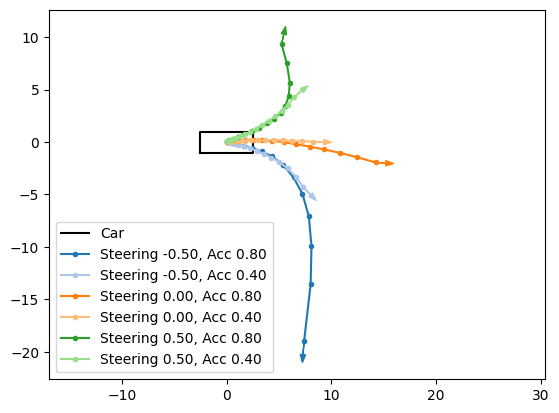

In [27]:
visualize_trajectories(dynamics, state=torch.Tensor([0, 0, 0, 0, 1, 0]))

The plot appears to be a visualization of different trajectories a car might follow based on varying steering and acceleration commands over a certain horizon. Here’s an interpretation of the plot:

- The black box represents the starting position and orientation of the car.
- Each line represents a potential path the car could take over time, with the arrow indicating the final position and direction after the sequence of actions.
- The colors distinguish between different combinations of steering angles and acceleration values.
- Trajectories with `Steering -0.50` turn sharply to the left, while those with `Steering 0.50` turn sharply to the right. The ones with `Steering 0.00` represent paths where the steering wheel is held straight.
- The solid lines indicate higher acceleration (`Acc 0.80`), leading to a longer path within the same time frame, compared to the dashed lines (`Acc 0.40`), which show lower acceleration.

Key Observations:

- The car turns more sharply at lower accelerations for the same steering angle, which can be seen from the tighter turning radius of the dashed lines compared to the solid ones.
- With no steering (`Steering 0.00`), the car moves straight, and the difference in acceleration is clear from the length of the trajectory.
- The plot successfully shows how different driving commands can lead to very different outcomes for the vehicle's position and orientation.

This visualization is likely used to predict the car's future state given different control inputs, which could be crucial for tasks such as autonomous driving, path planning, or control systems design. It's a useful tool for understanding how the car responds to commands and for designing control strategies that lead to desired behaviors.

## Reward model

In [28]:
def reward_model(states, goal, gamma=None):
    """
        The reward is a weighted L1-norm between the state and a goal
    :param Tensor states: a batch of states. shape: [batch_size, state_size].
    :param Tensor goal: a goal state. shape: [state_size].
    :param float gamma: a discount factor
    """
    goal = goal.expand(states.shape)
    reward_weigths = torch.Tensor(env.unwrapped.config["reward_weights"])
    rewards = -torch.pow(torch.norm((states-goal)*reward_weigths, p=1, dim=-1), 0.5)
    if gamma:
        time = torch.arange(rewards.shape[0], dtype=torch.float).unsqueeze(-1).expand(rewards.shape)
        rewards *= torch.pow(gamma, time)
    return rewards

obs, info = env.reset()
print("Reward of a sample transition:", reward_model(torch.Tensor(obs["observation"]).unsqueeze(0),
                                                     torch.Tensor(obs["desired_goal"])))

Reward of a sample transition: tensor([-0.5125])


## Leverage dynamics model for planning

We now use the learnt dynamics model for planning. In order to solve the optimal control problem, we use a sampling-based optimization algorithm: the Cross-Entropy Method (CEM). It is an optimization algorithm applicable to problems that are both combinatorial and continuous, which is our case: find the best performing sequence of actions.

In [29]:
def cem_planner(state, goal, action_size, horizon=5, population=100, selection=10, iterations=5):
    state = state.expand(population, -1)
    action_mean = torch.zeros(horizon, 1, action_size)
    action_std = torch.ones(horizon, 1, action_size)
    for _ in range(iterations):
        # 1. Draw sample sequences of actions from a normal distribution
        actions = torch.normal(mean=action_mean.repeat(1, population, 1), std=action_std.repeat(1, population, 1))
        actions = torch.clamp(actions, min=env.action_space.low.min(), max=env.action_space.high.max())
        states = predict_trajectory(state, actions, dynamics, action_repeat=5)
        # 2. Fit the distribution to the top-k performing sequences
        returns = reward_model(states, goal).sum(dim=0)
        _, best = returns.topk(selection, largest=True, sorted=False)
        best_actions = actions[:, best, :]
        action_mean = best_actions.mean(dim=1, keepdim=True)
        action_std = best_actions.std(dim=1, unbiased=False, keepdim=True)
    return action_mean[0].squeeze(dim=0)

In [30]:
# Run the planner on a sample transition
action = cem_planner(torch.Tensor(obs["observation"]),
                     torch.Tensor(obs["desired_goal"]),
                     env.action_space.shape[0])
print("Planned action:", action)

Planned action: tensor([0.9410, 0.1018])


In [31]:
env = record_videos(env)
obs, info = env.reset()

for step in trange(3 * env.config["duration"], desc="Testing 3 episodes..."):
    action = cem_planner(torch.Tensor(obs["observation"]),
                         torch.Tensor(obs["desired_goal"]),
                         env.action_space.shape[0])
    obs, reward, done, truncated, info = env.step(action.numpy())
    if done or truncated:
        obs, info = env.reset()
env.close()

c:\Users\oumai\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.config to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.config` for environment variables or `env.get_wrapper_attr('config')` that will search the reminding wrappers.
  logger.warn(
Testing 3 episodes...:   0%|          | 0/300 [00:00<?, ?it/s]

Testing 3 episodes...: 100%|██████████| 300/300 [00:47<00:00,  6.28it/s]


Differences Between This Method and DDPG:
- Model-Based vs. Model-Free: The approach in the notebook is model-based, focusing on learning the environment's dynamics. DDPG is a model-free method that directly learns a policy and value function without explicitly modeling the environment's dynamics.
- Usage: The learned dynamics model can be used for planning or to improve a policy, potentially in combination with model-free methods like DDPG. DDPG learns the policy based on trial and error in the environment, using a replay buffer and target networks to stabilize training.
- Objective: The primary objective in the notebook is accurate prediction of the environment's next state, while DDPG aims to maximize cumulative rewards by learning an optimal policy.
- Application: Model-based methods like the one described can be particularly beneficial in environments where sampling data is expensive, as they can leverage the learned model to simulate outcomes. DDPG and other model-free methods may require more interactions with the environment but are broadly applicable to various tasks without the need to learn an accurate model.